In [1]:
import astropy
import numpy as np
import pandas as pd
import matplotlib
import scipy

from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter 
from scipy import stats

In [2]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['text.color'] = 'Black'
plt.rcParams['font.size'] = '14'
plt.rcParams['figure.figsize'] = (12, 9)

In [5]:
file = fits.open('/Users/FRANNYPACK/Downloads/grind!/research/Data/MG_Stream_fg/the actual cube!.fits')
file.info()
file[0].header

Filename: /Users/FRANNYPACK/Downloads/grind!/research/Data/MG_Stream_fg/the actual cube!.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      90   (3551, 4151, 112)   float32   


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                 3551                                                  
NAXIS2  =                 4151                                                  
NAXIS3  =                  112                                                  
BUNIT   = 'K       '  /                                                         
DATE-OBS= '2020-05-09T21:46:39.0'  /                                            
TELESCOP= 'ASKAP   '  /                                                         
CRPIX1  =    1.90200000000E+03  /                                               
CDELT1  =   -1.94444444444E-03  /                                               
CRVAL1  =    2.62307458333E+01  /                                               
CTYPE1  = 'RA---SIN'  /     

In [6]:
# gets index of a specific velocity
def v_indx(v_val): # v_val must be in m/s
    v_indx = int((v_val - (4.27666857176 * 10 ** 4)) / (-9.77134909754 * 10 ** 2))
    return v_indx

# TOTAL COLUMN DENSITY (LS + SS)

In [16]:
# plots total column density

def col_dens(arr, vmin, vmax, subtitle, title = 'Column Density'):
    wcs = WCS(file[0].header)
    ax = plt.subplot(projection = wcs, slices = ['x','y',1], zorder = -1)
    plt.grid(b = True, which = 'major', axis = 'both', linewidth = 1, color = 'white')
    plt.xlabel('Right Ascension', fontsize = 20)
    plt.ylabel('Declination', fontsize = 20)
    plt.title(title, y = 1.06, fontsize = 30)
    plt.suptitle(subtitle, x = 0.5, y = 0.93, fontsize = 20)
    plt.imshow(arr, cmap = 'magma', vmin = vmin, vmax = vmax)
    plt.colorbar()

In [8]:
tot_col_dens = 1.82 * (10 ** 18) * np.nansum(file[0].data, axis = 0) * 0.977134909754 # in cm^-2, last val = velocity

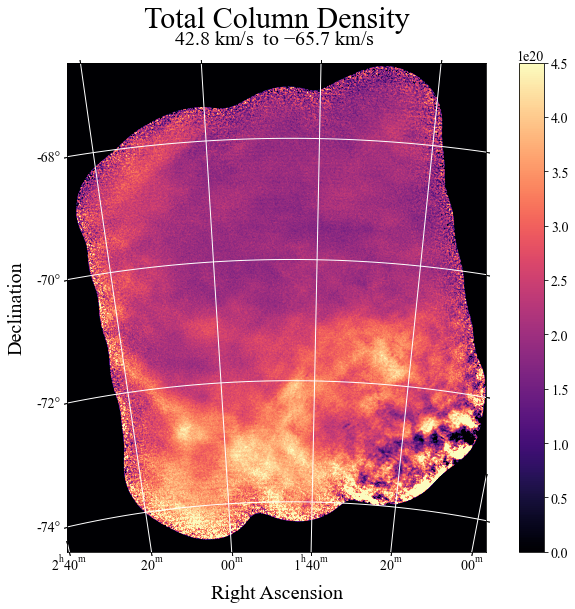

In [17]:
col_dens(tot_col_dens, 0,  4.5 * 10 ** 20, '$\mathregular{42.8}$ km/s  to $\mathregular{-65.7}$ km/s', 'Total Column Density')


In [18]:
# where most structure lies
col_dens1 = 1.82 * (10 ** 18) * np.nansum(file[0].data[v_indx(1.54 * 10 ** 4):v_indx(-1.10 * 10 ** 4)], axis = 0) * 0.977134909754


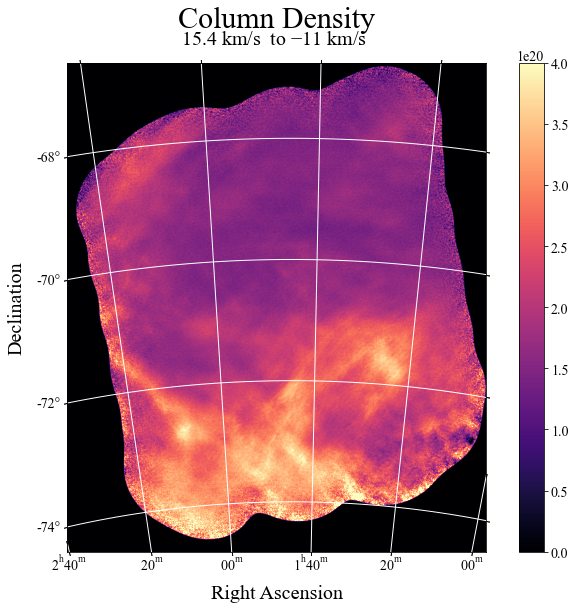

In [20]:
col_dens(col_dens1, 0,  4 * 10 ** 20, '$\mathregular{15.4}$ km/s  to $\mathregular{-11}$ km/s')


In [26]:

col_dens2 = 1.82 * (10 ** 18) * np.nansum(file[0].data[v_indx(1.54 * 10 ** 4):v_indx(4.66 * 10 ** 3)], axis = 0) * 0.977134909754


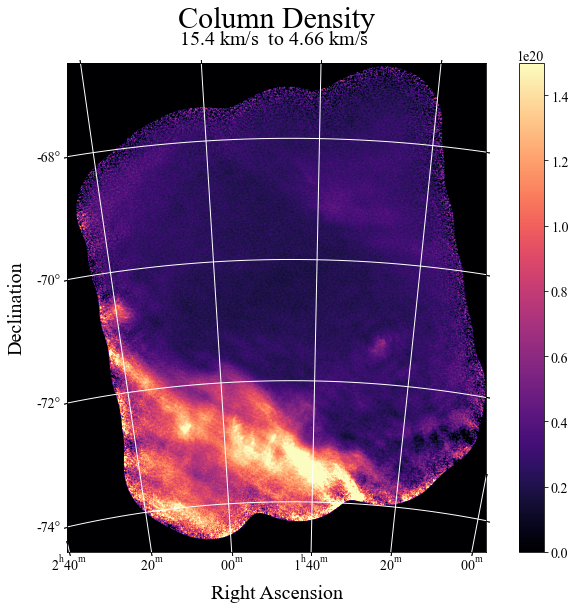

In [25]:
col_dens(col_dens2, 0,  1.5 * 10 ** 20, '$\mathregular{15.4}$ km/s  to $\mathregular{4.66}$ km/s')


In [27]:

col_dens3 = 1.82 * (10 ** 18) * np.nansum(file[0].data[v_indx(4.66 * 10 ** 3):v_indx(-1.10 * 10 ** 4)], axis = 0) * 0.977134909754


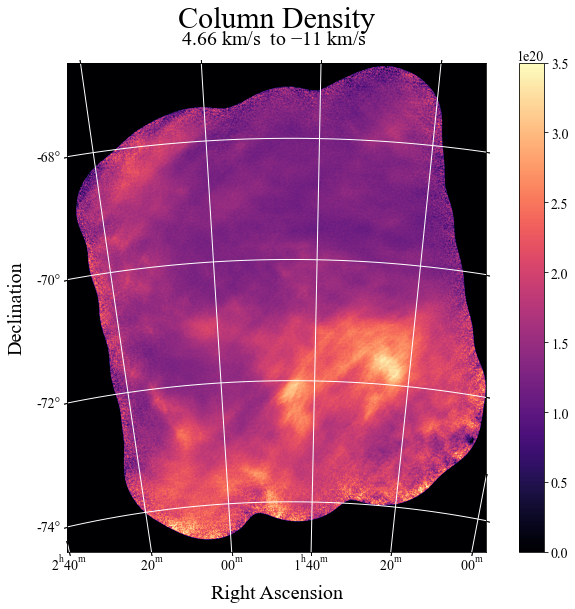

In [31]:
col_dens(col_dens3, 0,  3.5 * 10 ** 20, '$\mathregular{4.66}$ km/s  to $\mathregular{-11}$ km/s')


# SMALL-SCALE COLUMN DENSITY MAPS

In [32]:
# does the actual work of the USM

def process_usm(cc_sum, FWHM = 30.):
    
    pix_len = file[0].header['CDELT2'] * 60 # ['CDELT2'] = pixel length in deg, multiply by 60 to convert to arcmin
    FWHM30_pix = FWHM / pix_len # want FWHM to be 30 arcmin, so convert to pixels
    sigma = FWHM30_pix / (2 * np.sqrt(2 * np.log(2))) # converts from FWHM to sigma, since Gaussian filter specified by sigma
    sum_smooth = gaussian_filter(cc_sum, sigma = sigma) # does smoothing using Gaussian filter
    
    sum_USM = cc_sum - sum_smooth
    
    return sum_USM


In [35]:
# for multiple channel maps
# computes unsharp mask over 3 km/s at a time, then adds them up (so as to not wash out the small-scale structure)

def usm_cd(v_indx_min, v_indx_max, FWHM = 30., maskb = False):
    cur = v_indx_min
    num_iterations = int((v_indx_max - v_indx_min) / 3) # 3 km/s = 3 maps at a time
    tot_cd = np.zeros((4151, 3551))
    
    for i in range(num_iterations + 1):
        if (i == num_iterations): # remainder of 3 that we have to integrate over
            if ((v_indx_max - v_indx_min) % 3 == 0): # nothing left to integrate over - we done!
                return tot_cd
            else:
                cd_arr = 1.82 * (10 ** 18) * np.nansum(file[0].data[cur:v_indx_max], axis = 0) * 0.977134909754
        else: 
            cd_arr = 1.82 * (10 ** 18) * np.nansum(file[0].data[cur:cur + 3], axis = 0) * 0.977134909754
        
        if maskb:
            cd_arr = mask_border(cd_arr)
            
        tot_cd += process_usm(cd_arr, FWHM = FWHM)
        cur += 3

    tot_cd[np.where(tot_cd < 0.)] = 0. # at end so negative noise cancels out with positive noise
    return tot_cd

In [36]:
def show_usm(cd, vmin = 0, vmax = 0):
    plt.figure(figsize = (15, 9))
    plt.imshow(np.flip(np.abs(cd), axis = 0), cmap = 'magma', vmin = vmin, vmax = vmax)
    plt.colorbar()

In [43]:
tot_col_dens_SS = usm_cd(0, 111)

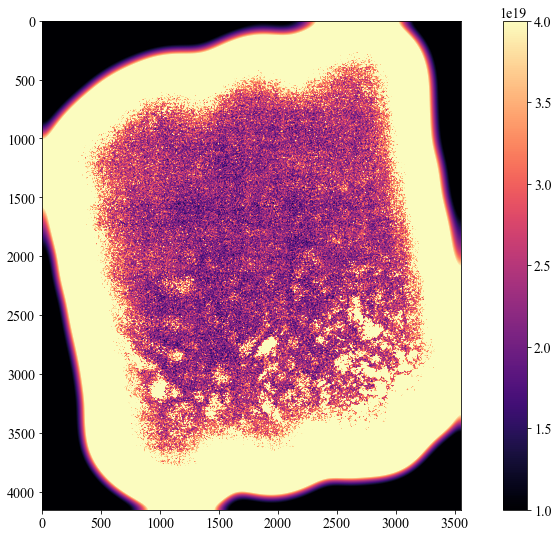

In [48]:
show_usm(tot_col_dens_SS, vmin = 1 * 10 ** 19, vmax = 4 * 10 ** 19)

In [38]:
# only integrated over all channel maps w/h structure tho

col_dens1_SS = usm_cd(v_indx(1.54 * 10 ** 4), v_indx(-1.10 * 10 ** 4))

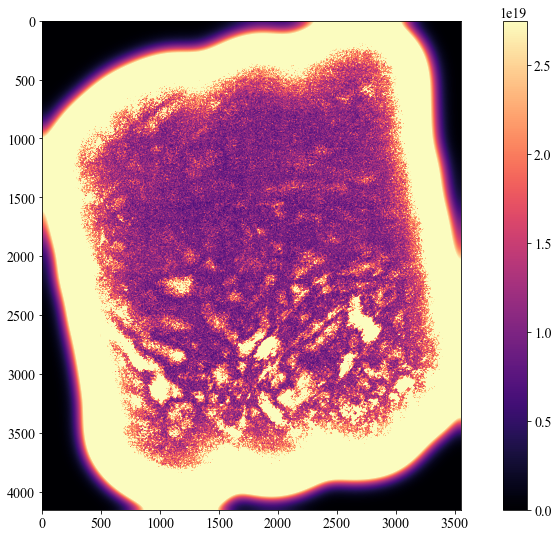

In [42]:
show_usm(col_dens1_SS, vmax = 2.75 * 10 ** 19)

In [49]:
col_dens2_SS = usm_cd(v_indx(1.54 * 10 ** 4), v_indx(4.66 * 10 ** 3))

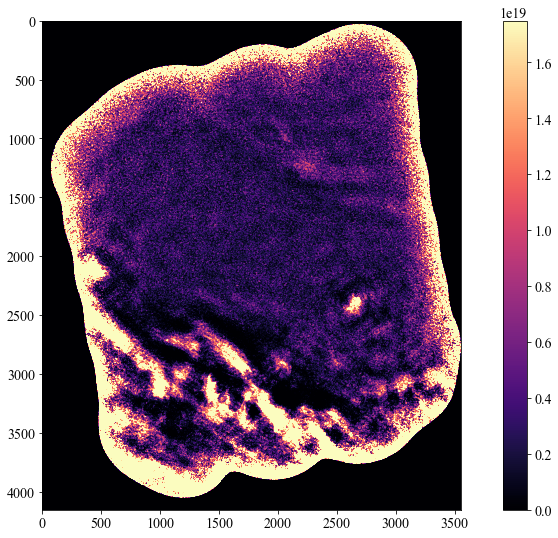

In [55]:
show_usm(col_dens2_SS, vmax = 1.75 * 10 ** 19)

In [56]:
col_dens3_SS = usm_cd(v_indx(4.66 * 10 ** 3), v_indx(-1.10 * 10 ** 4))

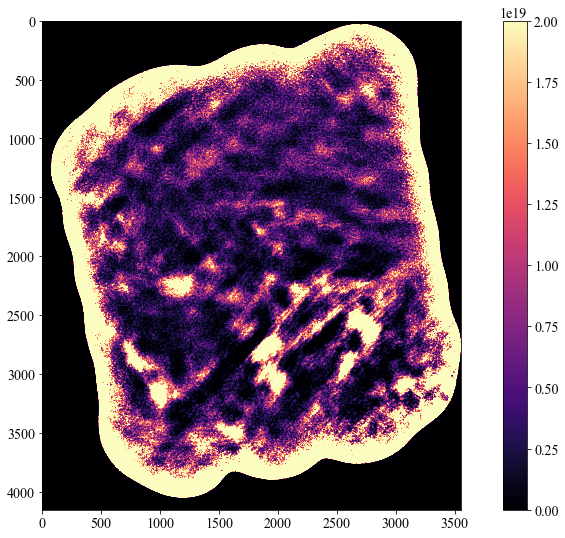

In [58]:
show_usm(col_dens3_SS, vmax = 2 * 10 ** 19)

# LARGE-SCALE COLUMN DENSITY MAPS

In [59]:
tot_col_dens_LS = tot_col_dens - tot_col_dens_SS

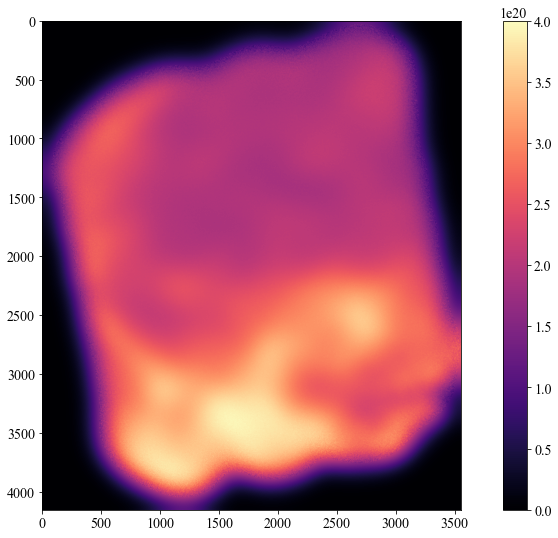

In [61]:
show_usm(tot_col_dens_LS, vmax = 4 * 10 ** 20)

In [62]:
col_dens1_LS = col_dens1 - col_dens1_SS

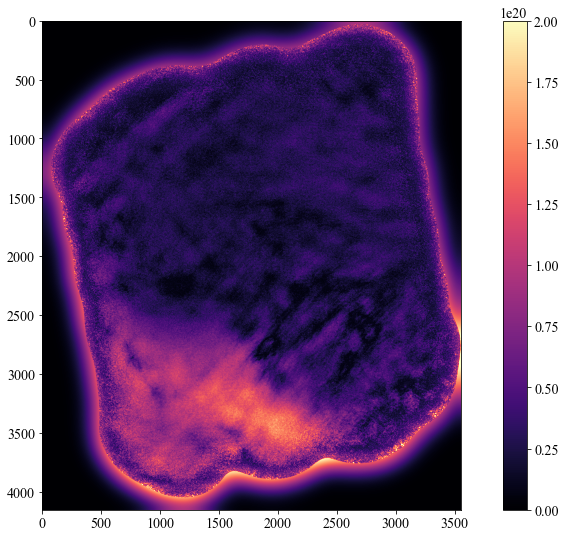

In [65]:
show_usm(col_dens1_LS, vmax = 2 * 10 ** 20)

In [66]:
col_dens2_LS = col_dens2 - col_dens2_SS

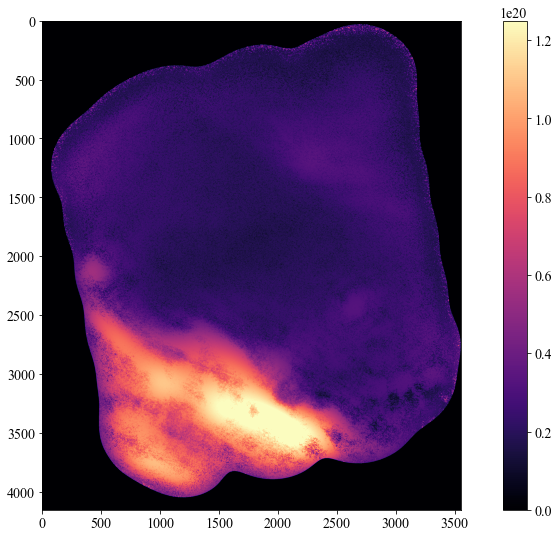

In [70]:
show_usm(col_dens2_LS, vmax = 1.25 * 10 ** 20)

In [71]:
col_dens3_LS = col_dens3 - col_dens3_SS

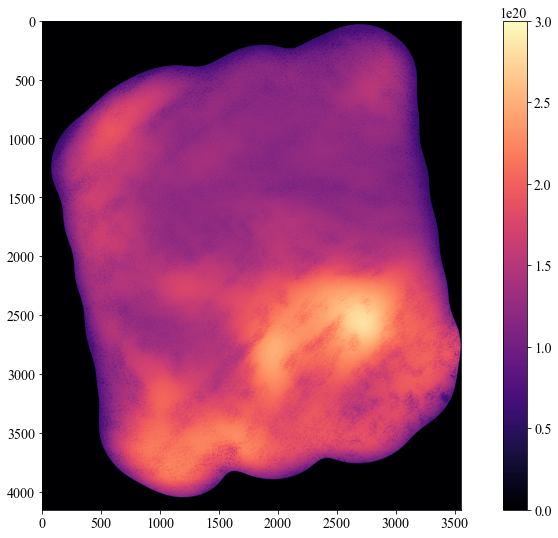

In [73]:
show_usm(col_dens3_LS, vmax = 3 * 10 ** 20)

# CALCULATING FRACTION OF SMALL-SCALE/LARGE-SCALE IN TOTAL COLUMN DENSITY

Using entire column density arrays

In [76]:
# much more filamentary structure than usual!

np.nansum(tot_col_dens_SS[np.where(tot_col_dens_SS > 0)]) / np.nansum(tot_col_dens[np.where(tot_col_dens_SS > 0)])

0.21552515338969527

In [77]:
np.nansum(tot_col_dens_LS[np.where(tot_col_dens_SS > 0)]) / np.nansum(tot_col_dens[np.where(tot_col_dens_SS > 0)])

0.7844751052488397

In [80]:
# this IS over the region where most filamentary structure lies, so that's fair

np.nansum(col_dens1_SS[np.where(col_dens1_SS > 0)]) / np.nansum(col_dens1[np.where(col_dens1_SS > 0)])

0.6819605158372526

In [81]:
np.nansum(col_dens1_LS[np.where(col_dens1_SS > 0)]) / np.nansum(col_dens1[np.where(col_dens1_SS > 0)])

0.31803948769778545

In [82]:
np.nansum(col_dens2_SS[np.where(col_dens2_SS > 0)]) / np.nansum(col_dens2[np.where(col_dens2_SS > 0)])

0.2806261553092989

In [84]:
np.nansum(col_dens2_LS[np.where(col_dens1_SS > 0)]) / np.nansum(col_dens1[np.where(col_dens1_SS > 0)])

0.7359551724194718

In [85]:
np.nansum(col_dens3_SS[np.where(col_dens3_SS > 0)]) / np.nansum(col_dens3[np.where(col_dens3_SS > 0)])

0.14953172946627696

In [86]:
np.nansum(col_dens3_LS[np.where(col_dens3_SS > 0)]) / np.nansum(col_dens3[np.where(col_dens3_SS > 0)])

0.8504690766113161

# ALL COLUMN DENSITY PLOTS TOGETHER

In [93]:
def all_cd(tot_arr, SS_arr, LS_arr, v_begin, v_end, tot_v_min, tot_v_max, LS_v_max, SS_v_min, SS_v_max):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 8), constrained_layout = True)
    fig.suptitle(str(v_begin) + ' km/s to ' + str(v_end) + ' km/s', y = 0.98, fontsize = 40)
    wcs = WCS(file[0].header)

    ax1.plot(projection = wcs, slices = ['x','y',1], zorder = -1)
    tot = ax1.imshow(np.flip(tot_arr, axis = 0), cmap = 'magma', vmin = tot_v_min, vmax = tot_v_max)
    ax1.set_title('Total Column Density', fontsize = 30)
    cbar1 = fig.colorbar(tot, ax = ax1, orientation = 'horizontal', pad = 0.1)
    
    ax2.plot(projection = wcs, slices = ['x','y',1], zorder = -1)
    LS = ax2.imshow(np.flip(LS_arr, axis = 0), cmap = 'magma', vmin = 0, vmax = LS_v_max)
    ax2.set_title('Large-Scale Column Density', fontsize = 30)
    fig.colorbar(LS, ax = ax2, orientation = 'horizontal', pad = 0.1)
    
    ax3.plot(projection = wcs, slices = ['x','y',1], zorder = -1)
    SS = ax3.imshow(np.flip(SS_arr, axis = 0), cmap = 'magma', vmin = SS_v_min, vmax = SS_v_max)
    ax3.set_title('Small-Scale Column Density', fontsize = 30)
    cbar = fig.colorbar(SS, ax = ax3, orientation = 'horizontal', pad = 0.1)

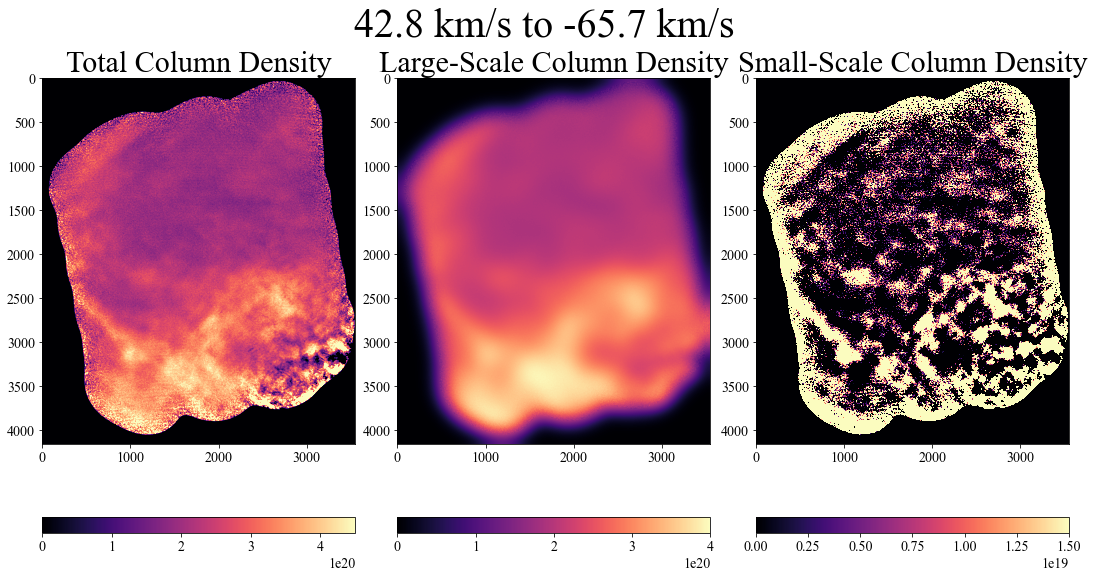

In [101]:
all_cd(tot_col_dens, tot_col_dens_SS, tot_col_dens_LS, 42.8, -65.7, 0,  4.5 * 10 ** 20, 4 * 10 ** 20, 0, 1.5 * 10 ** 19)



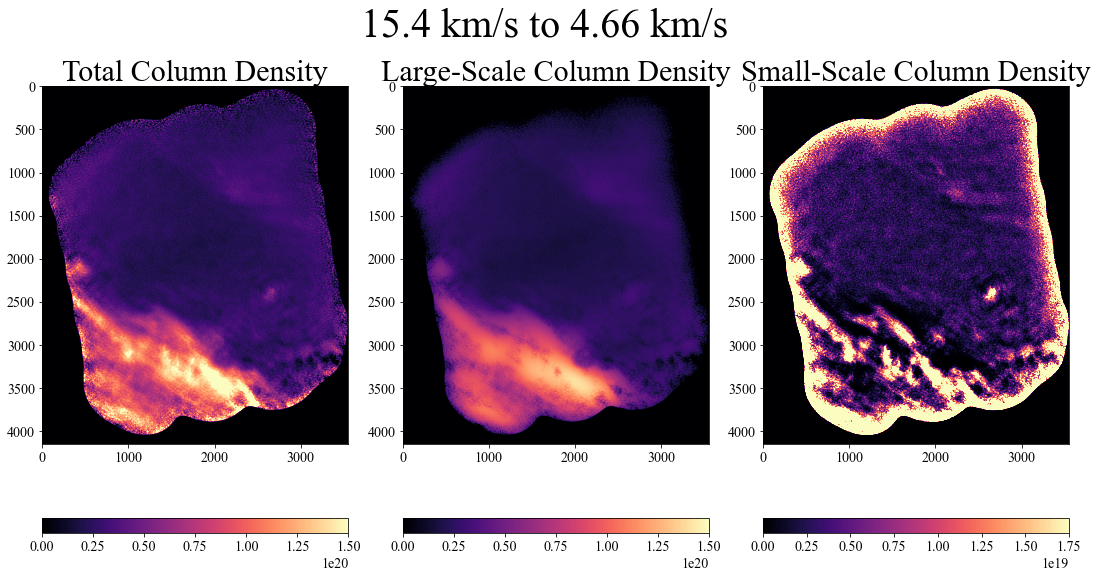

In [104]:
all_cd(col_dens2, col_dens2_SS, col_dens2_LS, 15.4, 4.66, 0,  1.5 * 10 ** 20, 1.5 * 10 ** 20, 0, 1.75 * 10 ** 19)



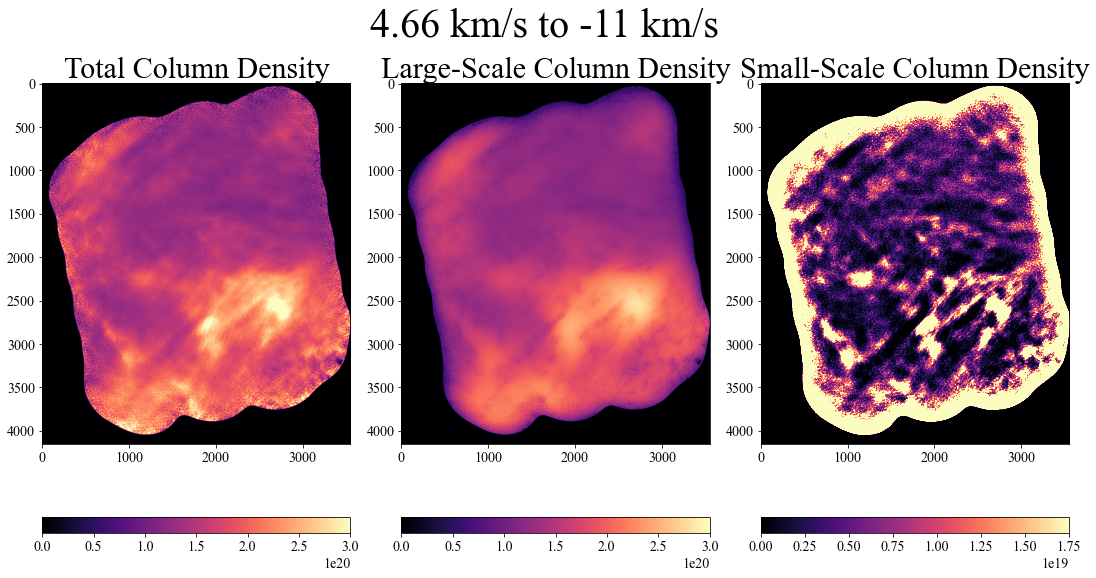

In [107]:
all_cd(col_dens3, col_dens3_SS, col_dens3_LS, 4.66, -11, 0,  3 * 10 ** 20, 3 * 10 ** 20, 0, 1.75 * 10 ** 19)

